## Overview

Given PCA coordinates generate a figure that captures the main structure identified.

In [1]:
import gcsfs
import zarr
import intake
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

In [2]:
import allel

In [3]:
from ag3 import release_data
v3 = release_data()

In [4]:
# Data storage, uses about 34 MB
pca_cloud_zarr_path_template = 'vo_agam_production/ag3_data_paper/{}.pca_output.zarr'
# Writing the PCA data to the cloud will require the appropriate authentication and authorization.

import gcsfs
# UNCOMMENT THIS TO AUTHENTICATE. YOU ONLY NEED TO RUN THIS ONCE.
# After running this once, your authentication token should then be cached in `~/.gcs_tokens`
# Once you have authenticated, you should comment this out again to avoid re-authenticating.
# gcs_browser = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='browser')

# Use `cache_timeout=0` to prevent object list cache, to avoid recreating map for Zarr consolidated metadata
auth_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

In [5]:
pca_cloud_zarr_path = pca_cloud_zarr_path_template.format('gamb_colu')
pca_cloud_zarr_path

'vo_agam_production/ag3_data_paper/gamb_colu.pca_output.zarr'

In [6]:
# Sometimes errors with `overwrite=True`, sometimes errors without, when dir not exist
# Keep the zarr_store for zarr.consolidate_metadata(zarr_store)
zarr_store = auth_fs.get_mapper(pca_cloud_zarr_path)
zarr_group = zarr.group(zarr_store)

In [7]:
list(zarr_group.keys())

['components', 'coords', 'explained_variance_ratio', 'sample_names']

In [8]:
sample_names = zarr_group["sample_names"][:]
sample_names = [s.decode() for s in sample_names]

In [9]:
pca_coordinates = zarr_group["coords"]
pca_components = zarr_group["components"]
pca_pve = zarr_group["explained_variance_ratio"]

In [10]:
list(zarr_group.keys())

['components', 'coords', 'explained_variance_ratio', 'sample_names']

In [11]:
all_meta = v3.load_sample_set_metadata(v3.all_wild_sample_sets)

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [12]:
all_meta.columns

Index(['partner_sample_id', 'contributor', 'country', 'location', 'year',
       'month', 'latitude', 'longitude', 'sex_call', 'sample_set',
       'aim_fraction_colu', 'aim_fraction_arab', 'species_gambcolu_arabiensis',
       'species_gambiae_coluzzii', 'is_arabiensis', 'is_gamb_colu',
       'is_gambiae', 'is_coluzzii'],
      dtype='object')

In [13]:
df_species_samples = all_meta.loc[sample_names]
df_species_samples.head()

partner_sample_id contributor country location  year  month  \
sample_id                                                               
AR0047-C             LUA047  Joao Pinto  Angola   Luanda  2009      4   
AR0049-C             LUA049  Joao Pinto  Angola   Luanda  2009      4   
AR0051-C             LUA051  Joao Pinto  Angola   Luanda  2009      4   
AR0061-C             LUA061  Joao Pinto  Angola   Luanda  2009      4   
AR0078-C             LUA078  Joao Pinto  Angola   Luanda  2009      4   

           latitude  longitude sex_call  sample_set  aim_fraction_colu  \
sample_id                                                                
AR0047-C     -8.884     13.302        F  AG1000G-AO              0.945   
AR0049-C     -8.884     13.302        F  AG1000G-AO              0.933   
AR0051-C     -8.884     13.302        F  AG1000G-AO              0.937   
AR0061-C     -8.884     13.302        F  AG1000G-AO              0.938   
AR0078-C     -8.884     13.302        F  AG1000G-AO              0.926   

           aim_fraction_arab species_gambcolu_arabiensis  \
sample_id                                                  
AR0047-C               0.001                   gamb_colu   
AR0049-C               0.001                   gamb_colu   
AR0051-C               0.002                   gamb_colu   
AR0061-C               0.002                   gamb_colu   
AR0078-C               0.001                   gamb_colu   

          species_gambiae_coluzzii  is_arabiensis  is_gamb_colu  is_gambiae  \
sample_id                                                                     
AR0047-C                  coluzzii          False          True       False   
AR0049-C                  coluzzii          False          True       False   
AR0051-C                  coluzzii          False          True       False   
AR0061-C                  coluzzii          False          True       False   
AR0078-C                  coluzzii          False          True       False   

           is_coluzzii  
sample_id               
AR0047-C          True  
AR0049-C          True  
AR0051-C          True  
AR0061-C          True  
AR0078-C          True

In [14]:
longitude_min = df_species_samples.longitude.min()
longitude_max = df_species_samples.longitude.max()

latitude_min = df_species_samples.latitude.min()
latitude_max = df_species_samples.latitude.max()

longitude_width = longitude_max - longitude_min
latitude_height = latitude_max - latitude_min

In [15]:
BBox = (longitude_min, longitude_max,      
         latitude_min, latitude_max)

In [16]:
# From https://stackoverflow.com/questions/56328254/how-to-make-the-conversion-from-barycentric-coordinates-to-cartesian-coordinates
b = np.array([0.25,0.3,0.45]) # Barycentric coordinates
t = np.transpose(np.array([[0,0],[1,0],[0,1]])) # Triangle
c = t.dot(b)
c

array([0.3 , 0.45])

In [63]:
import cartopy.feature as cfeature

In [64]:
cfeature.STATES

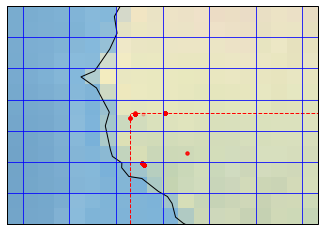

In [66]:
projection=  ccrs.PlateCarree()
transform = ccrs.PlateCarree()

ax = plt.axes(projection=projection)
ax.stock_img()


xlims = -20, -10
ylims = 10, 17



ax.set_xlim(*xlims)
ax.set_ylim(*ylims)

ax.scatter(
            df_species_samples.longitude,
            df_species_samples.latitude,
            zorder=1, alpha= 0.2, c='r', s=10,
            transform=transform
)

ax.add_patch(
                mpatches.Rectangle(
                    xy=[longitude_min, latitude_min], width=longitude_width, height=latitude_height,
                    edgecolor='red',
                    linestyle='--',
                    fill=False,
                    transform=transform
                )
             )

# ax.add_patch(
#                 mpatches.Polygon(
#                     xy=[
#                         [longitude_min - 10, latitude_max + 5],
#                         [longitude_max + 25, latitude_max + 5],
#                         [longitude_max / 2, latitude_min - 30]
#                     ],
#                     closed=True,
#                     facecolor='green',
#                     alpha=0.5, 
#                     transform=transform
#                 )

#              )

ax.gridlines(color='blue')
ax.coastlines()
ax.add_feature(cfeature.STATES.with_scale('50m'))
plt.show()

In [ ]:
ax.c

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns

## Perform PCA over latitude and longitude to find appropriate colours

In [19]:
ccode = pd.Series(pd.Categorical(df_species_samples.country).codes)

color_pal = sns.color_palette("husl", ccode.max() + 1)

plot_colors = ccode.map(lambda y: color_pal[y]).tolist()
color_pal

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9707505829046977, 0.4626541987597626, 0.26486329418330007),
 (0.8369430560927636, 0.5495828952802333, 0.1952683223448124),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.6430915736746491, 0.6271955086583126, 0.19381135329796756),
 (0.5310702086647983, 0.6569113639885688, 0.1931838276161326),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.1998437102815942, 0.6927711055021983, 0.4485948481767363),
 (0.20582072623426667, 0.6842209016721069, 0.5675558225732941),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2151139535594307, 0.6700707833028816, 0.7112365203426209),
 (0.22126158707091403, 0.6600977737826563, 0.7915486637100363),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.5392573577708815, 0.5821140171749066, 0.9584212824085171),
 (0.731751635642941, 0.5128186367840487, 0.9581005178234921),
 (0.9082572436765556, 0.40195790729656516, 0.95769

In [22]:
def reduce_geographical_dimensionality(latitudes, longitudes):
    
    X_features = np.hstack([latitudes.reshape((-1, 1)), longitudes.reshape((-1, 1))])
    assert X_features.shape[1] == 2

    scaler = StandardScaler()
    X_features = scaler.fit_transform(X_features)

    pca = PCA()
    pca.fit_transform(X_features)
    pca_variance = pca.explained_variance_

    coordinates = pca.transform(X_features)
    xv = coordinates[:, 0]
    yv = coordinates[:, 1]
    
    xv_for_map_col = (xv - xv.min())/(xv.max() - xv.min())
    return xv_for_map_col

In [23]:
# 'gist_rainbow'
cmap_name = 'nipy_spectral'
geog_v = reduce_geographical_dimensionality(all_meta.latitude.values, all_meta.longitude.values)

color_scheme = plt.get_cmap(cmap_name)(geog_v)

In [24]:
cs = pd.DataFrame(geog_v, index=all_meta.index)

In [25]:
df_species_samples["geog_values"] = cs.loc[sample_names].values

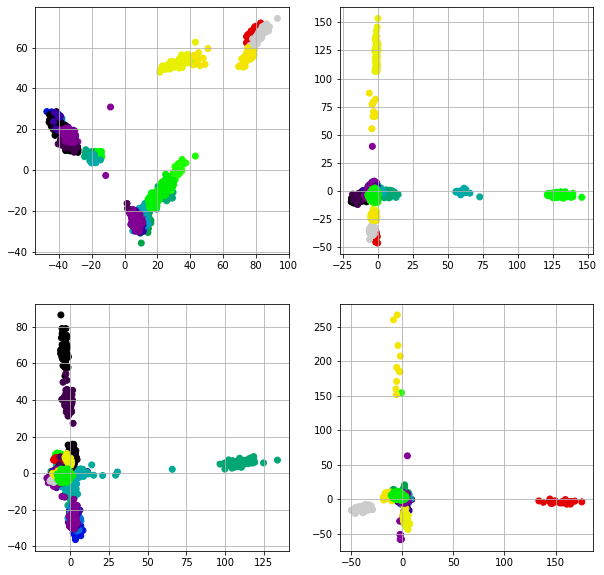

In [26]:
f, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

ax1, ax2 = ax[0]
ax3, ax4 = ax[1]

ax1.scatter(pca_coordinates[:, 0], pca_coordinates[:, 1], c=df_species_samples.geog_values, cmap=cmap_name)
ax1.grid(True)

ax2.scatter(pca_coordinates[:, 2], pca_coordinates[:, 3], c=df_species_samples.geog_values, cmap=cmap_name)
ax2.grid(True)


ax3.scatter(pca_coordinates[:, 4], pca_coordinates[:, 5], c=df_species_samples.geog_values, cmap=cmap_name)
ax3.grid(True)


ax4.scatter(pca_coordinates[:, 6], pca_coordinates[:, 7], c=df_species_samples.geog_values, cmap=cmap_name)
ax4.grid(True)

In [27]:
cs.loc[sample_names].drop_duplicates().shape

(121, 1)

## Display mapping of locations to colours

In [28]:
g = df_species_samples.drop_duplicates(subset="geog_values")
g = g.sort_values("geog_values")
g.shape

(121, 19)

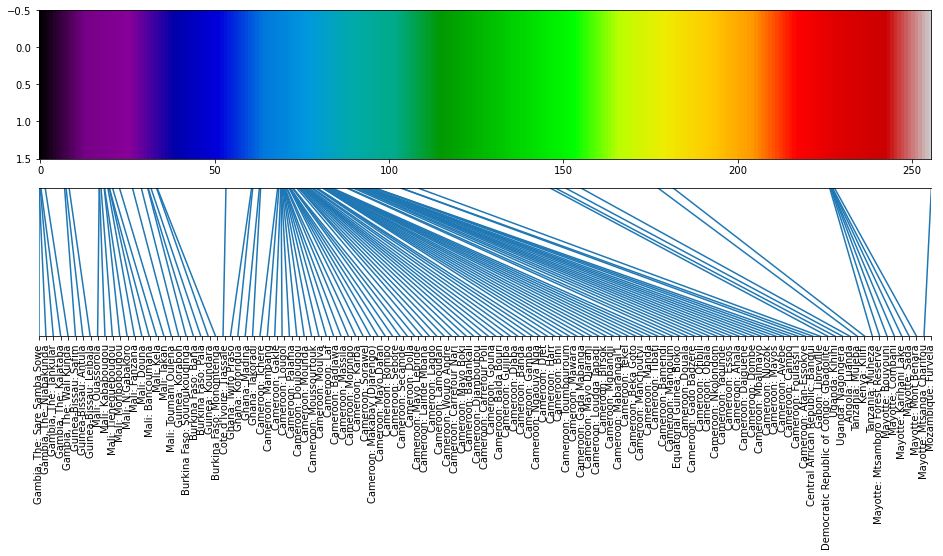

In [29]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 6))

ax1, ax2 = axes

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

ax1.imshow(gradient, aspect='auto', cmap=plt.get_cmap(cmap_name))

# for i, row in g.reset_index().iterrows():
#     v = row.geog_values
#     label = f"{row.country}: {row.location}"

labels = g.apply(lambda row: f"{row.country}: {row.location}", axis=1).values

allel.plot_variant_locator(g.geog_values.values, ax=ax2, flip=True)
ax2.xaxis.tick_bottom()

_ = ax2.set_xticks(np.linspace(0, 1, g.shape[0]))
_ = ax2.set_xticklabels(labels, rotation=90)
#ax3.set_xlim(0, 1)

## Attempt Bokeh

In [30]:
# let's try bokeh...
# imports required for `bokeh`
from bokeh.plotting import figure, show, ColumnDataSource, output_file
from bokeh.layouts import gridplot

In [76]:
import matplotlib as mpl

def plot_pca_coords(coords, pve, pc1, pc2, fig, df, group_var, col_dict="auto", query=None):

    x = coords[:, pc1]
    y = coords[:, pc2]
    
    qdf = df.reset_index().copy()
    qdf["x"] = x
    qdf["y"] = y
    
    # apply_query
    if query is not None:
        qdf = qdf.query(query)
    
    g = qdf.groupby(group_var)
    
    if col_dict == "auto":
        cp = sns.color_palette(n_colors=len(g))
        col_dict = {k:v for k, v in zip(g.groups, cp)}
        
    for label, frame in g:
        
        source = ColumnDataSource(data=frame)
        
        fig.circle(
            'x', 'y', 
            source=source,
            line_color='black',
            line_width=0.5,
            size=6,
            fill_color=mpl.colors.rgb2hex(col_dict[label]))
    
    fig.xaxis.axis_label = 'PC {0} ({1:.2f}%)'.format(
        pc1 + 1, 100 * pve[pc1])
    
    fig.yaxis.axis_label = 'PC {0} ({1:.2f}%)'.format(
        pc2 + 1, 100 * pve[pc2])
    
    return fig

In [72]:
df_species_samples.head()

location_label partner_sample_id contributor country location  year  \
sample_id                                                                       
AR0047-C        group109            LUA047  Joao Pinto  Angola   Luanda  2009   
AR0049-C        group109            LUA049  Joao Pinto  Angola   Luanda  2009   
AR0051-C        group109            LUA051  Joao Pinto  Angola   Luanda  2009   
AR0061-C        group109            LUA061  Joao Pinto  Angola   Luanda  2009   
AR0078-C        group109            LUA078  Joao Pinto  Angola   Luanda  2009   

           month  latitude  longitude sex_call  sample_set  aim_fraction_colu  \
sample_id                                                                       
AR0047-C       4    -8.884     13.302        F  AG1000G-AO              0.945   
AR0049-C       4    -8.884     13.302        F  AG1000G-AO              0.933   
AR0051-C       4    -8.884     13.302        F  AG1000G-AO              0.937   
AR0061-C       4    -8.884     13.302        F  AG1000G-AO              0.938   
AR0078-C       4    -8.884     13.302        F  AG1000G-AO              0.926   

           aim_fraction_arab species_gambcolu_arabiensis  \
sample_id                                                  
AR0047-C               0.001                   gamb_colu   
AR0049-C               0.001                   gamb_colu   
AR0051-C               0.002                   gamb_colu   
AR0061-C               0.002                   gamb_colu   
AR0078-C               0.001                   gamb_colu   

          species_gambiae_coluzzii  is_arabiensis  is_gamb_colu  is_gambiae  \
sample_id                                                                     
AR0047-C                  coluzzii          False          True       False   
AR0049-C                  coluzzii          False          True       False   
AR0051-C                  coluzzii          False          True       False   
AR0061-C                  coluzzii          False          True       False   
AR0078-C                  coluzzii          False          True       False   

           is_coluzzii  geog_values  
sample_id                            
AR0047-C          True     0.590414  
AR0049-C          True     0.590414  
AR0051-C          True     0.590414  
AR0061-C          True     0.590414  
AR0078-C          True     0.590414

In [77]:
# This defines what is displayed when the mouse hovers over a point.
# The @ values correspond to values in the table.
TOOLTIPS = [
    ("ox_code", "@sample_id"),
    ("country", "@country"),
    ("location", "@location"),
    ("collection year", "@year"),
    ("species", "@species_gambcolu_arabiensis"),
    ("species_gamcol", "@species_gambiae_coluzzii"),
    ("(x, y)", "($x, $y)"),]

In [78]:
components = np.array(range(8)).reshape((2, 2, 2)).tolist()

In [79]:
qlabel = pd.Series(data="", index=cs.index, name="qlabel")
qlabel

sample_id
AR0047-C     
AR0049-C     
AR0051-C     
AR0061-C     
AR0078-C     
           ..
AC0295-C     
AC0296-C     
AC0297-C     
AC0298-C     
AC0299-C     
Name: qlabel, Length: 2784, dtype: object

In [80]:
i = 0
for q, z in cs.groupby(0).groups.items():
    qlabel.loc[z] = f"group{i}"
    i += 1

In [81]:
f = pd.concat([qlabel, cs], axis=1).set_index("qlabel").drop_duplicates()
f = pd.DataFrame(plt.get_cmap(cmap_name)(f[0]), index=f.index)
pop_colours = {s: x.values for s, x in f.iterrows()}

In [82]:
try:
    df_species_samples.insert(0, "location_label", qlabel.loc[sample_names])
except ValueError:
    pass

In [91]:
qq = 'country in ("Gambia, The", "Guinea-Bissau")'

In [92]:
output_file("pca_plots.html")
grid = []

for row in components:
    
    l = []
    
    for (c1, c2) in row:

        p = figure(plot_width=400, plot_height=400, tooltips=TOOLTIPS)
        l.append(
            plot_pca_coords(
                pca_coordinates, 
                pca_pve, 
                c1, 
                c2, 
                p,
                df_species_samples,
                "location",
                col_dict="auto",
                query=qq))
                #"location_label"))
        
    grid.append(l)

col = gridplot(grid)
show(col)

In [93]:
df_species_samples.country.value_counts()

Cameroon                        442
Burkina Faso                    293
Gambia, The                     279
Mali                            223
Uganda                          207
Guinea                          136
Guinea-Bissau                   101
Ghana                           100
Angola                           81
Cote d'Ivoire                    80
Democratic Republic of Congo     76
Tanzania                         75
Mozambique                       74
Central African Republic         73
Kenya                            73
Gabon                            69
Mayotte                          23
Equatorial Guinea                10
Name: country, dtype: int64

In [94]:
g = df_species_samples.query(qq).groupby("location")

In [95]:
g.first()

location_label partner_sample_id       contributor  \
location                                                             
Antula                  group6            BIS001        Joao Pinto   
Kalataba                group3          002-1125  Beniamino Caputo   
Leibala                 group7        10GBL_0348        Joao Pinto   
Njabakunda              group1              2614   Martin Donnelly   
Safim                   group5        10GBS_0607        Joao Pinto   
Sare Samba Sowe         group0          009-1006  Beniamino Caputo   
Tankular                group2          001-1048  Beniamino Caputo   
Wali Kunda              group4              I-73   Charles Godfray   

                       country  year  month  latitude  longitude sex_call  \
location                                                                    
Antula           Guinea-Bissau  2010     -1    11.891    -15.582        F   
Kalataba           Gambia, The  2012      8    13.550    -15.617      UKN   
Leibala          Guinea-Bissau  2010     -1    12.272    -14.222        F   
Njabakunda         Gambia, The  2011      8    13.550    -15.900        F   
Safim            Guinea-Bissau  2010     -1    11.957    -15.649        F   
Sare Samba Sowe    Gambia, The  2012      8    13.583    -15.900      UKN   
Tankular           Gambia, The  2012      8    13.417    -16.033      UKN   
Wali Kunda         Gambia, The  2012     10    13.567    -14.917        F   

                   sample_set  aim_fraction_colu  aim_fraction_arab  \
location                                                              
Antula             AG1000G-GW              0.080              0.006   
Kalataba         AG1000G-GM-B              0.918              0.005   
Leibala            AG1000G-GW              0.032              0.003   
Njabakunda       AG1000G-GM-A              0.152              0.005   
Safim              AG1000G-GW              0.131              0.006   
Sare Samba Sowe  AG1000G-GM-B              0.108              0.005   
Tankular         AG1000G-GM-B              0.844              0.006   
Wali Kunda       AG1000G-GM-C              0.943              0.005   

                species_gambcolu_arabiensis species_gambiae_coluzzii  \
location                                                               
Antula                            gamb_colu                  gambiae   
Kalataba                          gamb_colu                 coluzzii   
Leibala                           gamb_colu                  gambiae   
Njabakunda                        gamb_colu             intermediate   
Safim                             gamb_colu             intermediate   
Sare Samba Sowe                   gamb_colu                  gambiae   
Tankular                          gamb_colu             intermediate   
Wali Kunda                        gamb_colu                 coluzzii   

                 is_arabiensis  is_gamb_colu  is_gambiae  is_coluzzii  \
location                                                                
Antula                   False          True        True        False   
Kalataba                 False          True       False         True   
Leibala                  False          True        True        False   
Njabakunda               False          True       False        False   
Safim                    False          True       False        False   
Sare Samba Sowe          False          True        True        False   
Tankular                 False          True       False        False   
Wali Kunda               False          True       False         True   

                 geog_values  
location                      
Antula              0.030755  
Kalataba            0.002617  
Leibala             0.034263  
Njabakunda          0.000555  
Safim               0.029158  
Sare Samba Sowe     0.000000  
Tankular            0.001821  
Wali Kunda          0.007432

In [ ]:
plt.scatter(df_species_samples.longitude, df_species_samples.latitude, c=plot_colors)

In [ ]:
# broadly speaking in an E/W plane.

# 


In [ ]:
# https://stackoverflow.com/questions/31967472/smooth-interpolated-tertiary-or-quaternary-colour-scales-e-g-r-g-b-triangle

## Population definitions

Populations must be disjoint!

In [102]:
df_species_samples["PC1"] = pca_coordinates[:, 0]
df_species_samples["PC2"] = pca_coordinates[:, 1]

In [123]:
definition_file = "../content/population_definitions.yml"

In [124]:
population_definitions = {}

In [125]:
df_species_samples.columns

Index(['location_label', 'partner_sample_id', 'contributor', 'country',
       'location', 'year', 'month', 'latitude', 'longitude', 'sex_call',
       'sample_set', 'aim_fraction_colu', 'aim_fraction_arab',
       'species_gambcolu_arabiensis', 'species_gambiae_coluzzii',
       'is_arabiensis', 'is_gamb_colu', 'is_gambiae', 'is_coluzzii',
       'geog_values', 'PC1', 'PC2'],
      dtype='object')

In [126]:
population_definitions["GM_col"] = df_species_samples.query(
    "country == 'Gambia, The'").query(
        "species_gambiae_coluzzii == 'coluzzii'").index.values.tolist()

In [127]:
population_definitions["GM_im"] = df_species_samples.query(
    "country == 'Gambia, The'").query(
        "species_gambiae_coluzzii != 'coluzzii'").query(
            "PC1 < 0").index.values.tolist()
population_definitions["GM_im"]

['AG0147-C',
 'AG0159-C',
 'AG0232-C',
 'AG0129-C',
 'AG0153-C',
 'AG0163-C',
 'AG0229-C',
 'AG0230-C',
 'AG0098-C',
 'AG0104-C',
 'AG0106-C',
 'AG0120-C',
 'AG0136-C',
 'AG0141-C',
 'AG0145-C',
 'AG0148-C',
 'AG0172-C',
 'AG0179-C',
 'AG0223-C',
 'AG0118-C',
 'AG0119-C',
 'AG0121-C',
 'AG0133-C',
 'AG0134-C',
 'AG0138-C',
 'AG0227-C',
 'AG0231-C',
 'AG0102-C',
 'AG0108-C',
 'AG0123-C',
 'AG0128-C',
 'AG0137-C',
 'AG0139-C',
 'AG0143-C',
 'AG0162-C',
 'AG0170-C',
 'AG0181-C',
 'AG0085-C',
 'AG0096-C',
 'AG0126-C',
 'AG0152-C',
 'AG0183-C',
 'AG0208-C',
 'AG0214-C',
 'AG0226-C',
 'AG0127-C',
 'AG0144-C',
 'AG0156-C',
 'AG0206-C',
 'AG0221-C',
 'AG0234-C',
 'AG0082-C',
 'AG0097-C',
 'AG0100-C',
 'AG0109-C',
 'AG0124-C',
 'AG0142-C',
 'AG0146-C',
 'AG0169-C',
 'AG0178-C',
 'AG0195-C',
 'AG0089-C',
 'AG0111-C',
 'AG0125-C',
 'AG0197-C',
 'AG0202-C',
 'AG0203-C',
 'AG0204-C',
 'AG0263-C',
 'AG0382-CW',
 'AG0394-CW',
 'AG0404-CW',
 'AG0405-CW',
 'AG0420-CW',
 'AG0442-CW',
 'AG0445-CW',
 'AG0

In [128]:
assert set(population_definitions["GM_im"]).isdisjoint(population_definitions["GM_col"])

In [129]:
population_definitions["GW_im"] = df_species_samples.query(
    "country == 'Guinea-Bissau'").query(
        "PC1 < 0").index.values.tolist()

In [130]:
population_definitions["GW_gam"] = df_species_samples.query(
    "country == 'Guinea-Bissau'").query(
        "PC1 > 0").index.values.tolist()
population_definitions["GW_gam"]

['AJ0120-C',
 'AJ0121-C',
 'AJ0122-C',
 'AJ0123-C',
 'AJ0124-C',
 'AJ0125-C',
 'AJ0126-C',
 'AJ0127-C']

In [131]:
from itertools import combinations
import yaml

## Check and write to file

In [132]:
for a, b in combinations(population_definitions.keys(), 2):
    
    set1 = set(population_definitions[a])
    set2 = set(population_definitions[b])
    
    assert set1.isdisjoint(set2), f"{a} and {b} are not disjoint. Share {set1.intersection(set2)}"
    

with open(definition_file, mode="w") as wr:
    print(yaml.dump(population_definitions), file=wr)